# Heat equation in 2D: joint estimation of the solution and the diffusion 

Consider the following PDE on $\Omega=[0,1]^2$:
$$
\begin{cases}
\frac{\partial}{\partial t}u(x,y)-\nabla(a(x,y)\nabla u(x,y)) = f(x, y),\\
f(x,y)=((4\pi^2-1)\sin\pi x\sin\pi y + \pi^2(2\sin^2\pi x\sin^2\pi y-\cos^2\pi \sin^2 \pi y - \sin^2\pi x\cos^2\pi y))e^{-t}, \text{ (source term)}.
\end{cases}
$$
On the boundary $\partial\Omega$ we set
$$
a(x,y) = 2.
$$

We get that the true solution on $\Omega$ that we will estimate with a PINN is 
$$
u(x,y)=e^{-t}\sin\pi x\sin\pi y.
$$
The ground truth on $\Omega$ of the diffusion coefficient is
$$
a(x,y) = 2+\sin\pi x\sin\pi y.
$$

This is a **jinns** reimplementation of the inverse problem studied in [this article](https://arxiv.org/pdf/2306.08827.pdf) for example, the original code is available [here](https://github.com/i207M/PINNacle/blob/main/src/pde/inverse.py#L58).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable


Import our package

In [3]:
import jinns


Import other dependencies

In [4]:
import jax
import numpy as np
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial
import matplotlib.pyplot as plt

key = random.PRNGKey(2)
key, subkey = random.split(key)

## Observations

We simulate some observations

In [5]:
def u_true(t, x):
    return jnp.exp(-t) * jnp.sin(jnp.pi * x[0]) * jnp.sin(jnp.pi * x[1])
v_u_true = vmap(u_true)

# nx = 1000
# val_xydata = [jnp.linspace(xmin, xmax, nx), jnp.linspace(xmin, xmax, nx)]
# times = [0., 0.2, 0.55, 0.8, 0.99] # times in the rescaled time susescale

# jinns.data.plot2d(u_true, xy_data=val_xydata, times=times, cmap="viridis", figsize=(10,10), title="u_true(x, y)")

In [6]:
key, subkey = jax.random.split(key)
n_obs = 2500
x = jax.random.uniform(subkey, shape=(n_obs, 2), minval=-1.0, maxval=1.0)
t = jax.random.uniform(subkey, shape=(n_obs, 1), minval=0.0, maxval=1.0)
obs = v_u_true(t, x)

obs_batch = jnp.concatenate([
    t[..., 0:1], x[..., 0:2], obs
    ], axis=-1)
print(obs_batch.shape)

(2500, 4)


__Optionally blur the observed values__

In [7]:
obs_batch_ori = obs_batch.copy()
key, subkey = jax.random.split(key)
obs_batch = obs_batch.at[:, 3].set(
    obs_batch[:, 3] +
    0 #random.normal(subkey, obs_batch[:, 2].shape) * 0.01
)

Create the neural network architecture for the PINN. The network will have two outputs:

- $u(x,y)$, the classical PINN output
- $a(x, y)$. This secondary PINN output should then be treated as the diffusion coefficient, i.e., an equation parameter. In **jinns**, we know that the equation parameters are fed through the dictionary `params["eq_params"]`. If we want one of the equation parameters to be taken as a PINN output, one then needs to specify a transform with the `eq_params_heterogeneity` argument. See below in the loss construction.

In [8]:
eqx_list = [
    [eqx.nn.Linear, 3, 50], # 3 = t + x (2D)
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 2]
]

key, subkey = random.split(key)
u = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 2, slice_solution=jnp.s_[0:1])
init_nn_params = u.init_params()

In [9]:
init_params = {
    "nn_params":init_nn_params,
    "eq_params":{
        "a":0. # The second output of the PINN will correspond to the diffusion coefficient, so the value here is irrelevant
    }
}

Create a DataGenerator object

In [10]:
n = 500
nt = 500
nb = 320
omega_batch_size = 32
temporal_batch_size = 32
omega_border_batch_size = 32
dim = 2
xmin = -1
xmax = 1
tmin = 0
tmax = 1
Tmax = 1
method = "uniform"

train_data = jinns.data.CubicMeshPDENonStatio(
    subkey,
    n,
    nb,
    nt,
    omega_batch_size,
    omega_border_batch_size,
    temporal_batch_size,
    dim,
    (xmin, xmin),
    (xmax, xmax),
    tmin,
    tmax,
    method
)


## Loss construction

Create the 2D Heat loss. The loss contains **heterogeneous parameters** that can be managed in two steps:

1. Define a dictionary `eq_params_heterogeneity` with any kind of functions that should be applied to the equation parameters. Here, the diffusion parameter (`params["eq_params"]["a"]`) is set to the second output of the PINN with a custom transform function that we give at key `"a"` of the `eq_params_heterogeneity` dictionary. Note that whatever the transform, the arguments of the such a function must be `t, x, u, params` in the stationary case.

2. Transform the parameters according to the content of the dictionary `eq_params_heterogeneity` at each call to `evaluate`. This can be done simply by decorating the `evaluate()` method with `@evaluate_heterogeneous_parameters`. The equivalent code of such decorator would be:
```
params["eq_params"] = self.eval_heterogeneous_parameters(
     t, x, u, params, self.eq_params_heterogeneity)
```

In [11]:
def a_to_pinn_output(t, x, u, params):
    """
    A jittable function that attributes the second output of u to the diffusion coefficient a
    """
    return lambda t, x, params: u(t, x, params)[1]
eq_params_heterogeneity = {"a": a_to_pinn_output} # STEP 1.

In [12]:
from jinns.loss._DynamicLossAbstract import PDENonStatio

class HeatLoss2D(PDENonStatio):
    def __init__(self, eq_params_heterogeneity):
        super().__init__(eq_params_heterogeneity=eq_params_heterogeneity)
        
    @PDENonStatio.evaluate_heterogeneous_parameters # STEP 2.
    def evaluate(self, t, x, u, params):
        # Because of the decoration with evaluate_heterogeneous_parameters the params we receive are already modified with the user defined 
        # eq_params_heterogeneity
        
        u_pinn = lambda t, x, params: jnp.squeeze(u(t, x, params)[u.slice_solution]) # Grab the slice corresponding to solution (jnp.s_[0:1])
        def source_term(t, x, params):
            x, y = x[0], x[1]
            return (
                ((4 * jnp.pi ** 2 - 1) * jnp.sin(jnp.pi * x) * jnp.sin(jnp.pi * y) +
                     jnp.pi ** 2 * (2 * jnp.sin(jnp.pi * x) ** 2 * jnp.sin(jnp.pi * y) ** 2 -
                        jnp.cos(jnp.pi * x) ** 2 * jnp.sin(jnp.pi * y) ** 2 -
                        jnp.sin(jnp.pi * x) ** 2 * jnp.cos(jnp.pi * y) ** 2)
                ) * jnp.exp(-t)
            )
        a_times_jac_u = lambda t, x, params: params["eq_params"]["a"](t, x, params) * jax.jacrev(u_pinn, 1)(t, x, params)
        return (jax.grad(u_pinn, 0)(t, x, params)
                - jinns.loss._operators._div_rev(a_times_jac_u, params, t, x)
                - source_term(t, x, params)
               )

In [13]:
heat_loss = HeatLoss2D(
    eq_params_heterogeneity=eq_params_heterogeneity
)

Create the boundary function and the global loss

In [14]:
loss_weights = {"dyn_loss":100., "boundary_loss":10., "observations":10.}

loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=heat_loss,
    omega_boundary_fun=lambda t, dx: 2.,#+jnp.sin(jnp.pi * dx[0])*jnp.sin(jnp.pi * dx[1]),
    omega_boundary_condition="dirichlet",
    omega_boundary_dim=jnp.s_[1], # the second output of the PINN is the one with enforced boundary condition
    obs_batch=[obs_batch[:, 0], obs_batch[:, 1:3],  obs_batch[:, 3]]
)


In [15]:
# Testing the loss function
losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
key, subkey = random.split(key)
losses, grads = losses_and_grad(
    init_params,
    batch = train_data.get_batch()
)


l_tot, d = losses
print(f"total loss: {l_tot:.2f}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")

total loss: 11956.82
Individual losses: {'boundary_loss': '178.17', 'dyn_loss': '11777.44', 'initial_condition': '0.00', 'norm_loss': '0.00', 'observations': '1.21', 'sobolev': '0.00'}


## Joint estimation of `a(x,y)` and `nn_params`

In [16]:
params = init_params


Below we can test either the alternating optimizer or the delayed optimizer provided by `jinns` to alter the optimization process whether we consider the PINN parameters or the equation parameters.

In [24]:
import optax
n_iter = 100000
tx = optax.adamw(learning_rate=5e-4)

Then optimization starts

In [25]:
key, subkey = random.split(key, 2)
params, total_loss_list, loss_by_term_dict, train_data, loss, _, tracked_params = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
    print_loss_every=10000
)

  0%|          | 0/50000 [00:00<?, ?it/s]

Iteration 0: loss value = 114.36473083496094
Iteration 10000: loss value = 4.090433120727539
Iteration 20000: loss value = 3.1727240085601807
Iteration 30000: loss value = 1.7941255569458008
Iteration 40000: loss value = 1.927727460861206
Iteration 50000: loss value = 1.6973199844360352


## Results

Plot the loss values

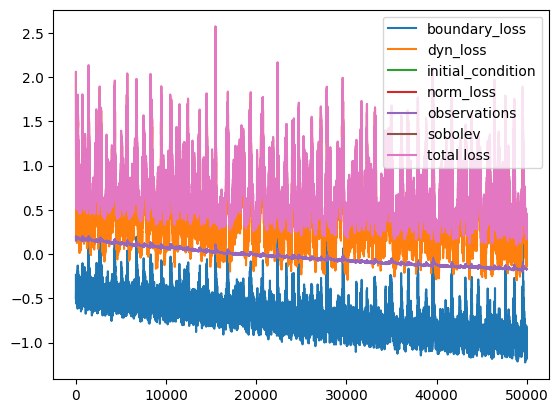

In [26]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();


Plot the PDE solutions learned by the PINN

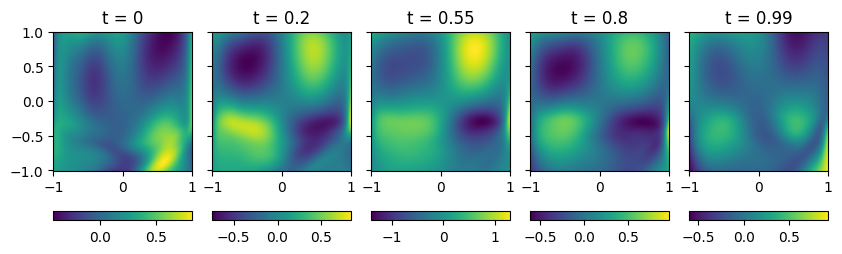

In [27]:
u_est = lambda t, x: u(t, x, params)[0]
nx = 1000
val_xydata = [jnp.linspace(xmin, xmax, nx), jnp.linspace(xmin, xmax, nx)]
times = [0, 0.2, 0.55, 0.8, 0.99] # times in the rescaled time susescale

jinns.data.plot2d(u_est, xy_data=val_xydata, times=times, cmap="viridis", figsize=(10,10), title="u(x, y)")

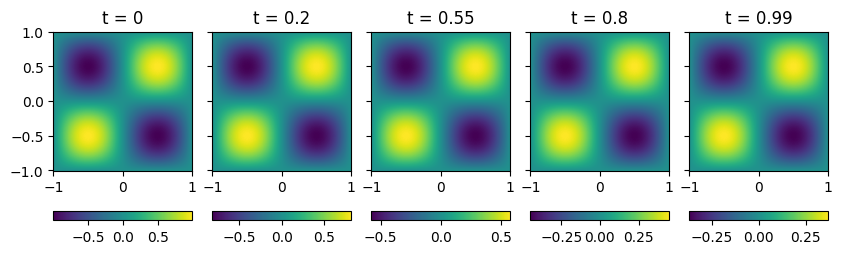

In [28]:
nx = 1000
jinns.data.plot2d(u_true, xy_data=val_xydata, times=times, cmap="viridis", figsize=(10,10), title="u_true(x, y)")

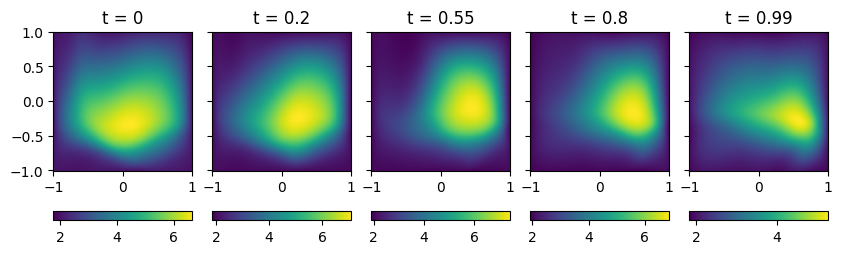

In [29]:
a_est = lambda t, x: u(t, x, params)[1]
nx = 1000
jinns.data.plot2d(a_est, xy_data=val_xydata, times=times, cmap="viridis", figsize=(10,10), title="a(x, y)")

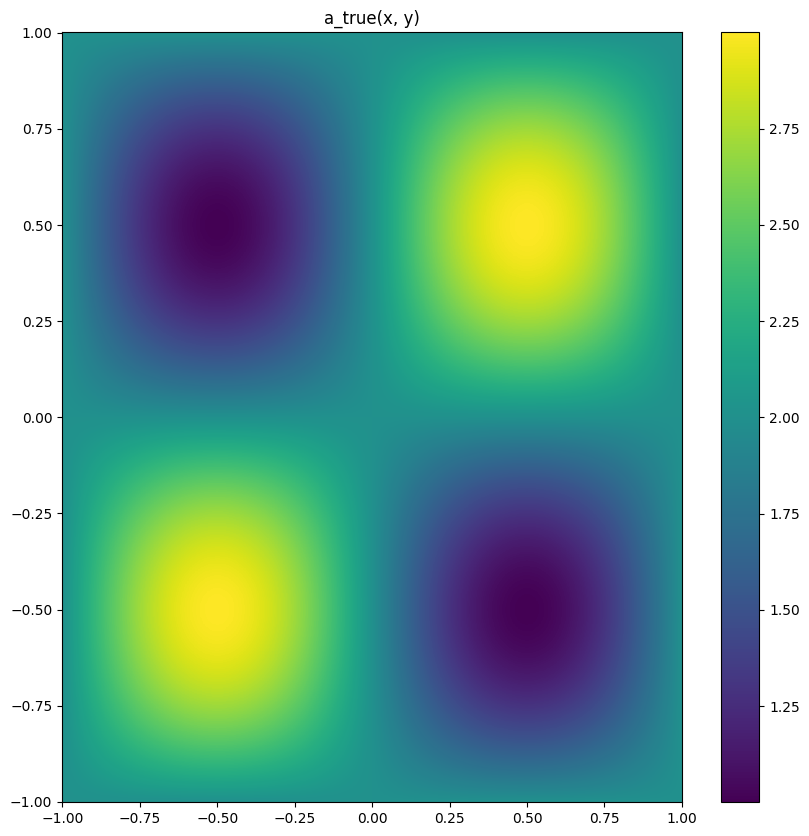

In [30]:
def a_true(dx):
    dx, dy = dx[0], dx[1]
    return 2 + jnp.sin(jnp.pi * dx) * jnp.sin(jnp.pi * dy)

nx = 1000
val_xydata = [jnp.linspace(xmin, xmax, nx), jnp.linspace(xmin, xmax, nx)]
jinns.data.plot2d(a_true, xy_data=val_xydata, times=None, cmap="viridis", figsize=(10,10), title="a_true(x, y)")